In [119]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
from torch.utils.data import TensorDataset,DataLoader
import matplotlib.pyplot as plt

In [120]:
data = pd.read_csv('../traffic/data/5.csv')
data

,service_name,datetime,volumn,packets,unknown
0,S201709282113260015,2018-07-25 00:00:00,92408,26971036,177711644
1,S201709282113260015,2018-07-25 00:01:00,92150,26948190,220370286
2,S201709282113260015,2018-07-25 00:02:00,94896,26238222,188035073
3,S201709282113260015,2018-07-25 00:03:00,92694,26087970,191997884
4,S201709282113260015,2018-07-25 00:04:00,93674,25314568,169497214
...,...,...,...,...,...
38875,S201709282113260015,2018-08-20 23:55:00,81521,23637112,138239574
38876,S201709282113260015,2018-08-20 23:56:00,83092,24617816,164460450
38877,S201709282113260015,2018-08-20 23:57:00,84873,25101336,173568370
38878,S201709282113260015,2018-08-20 23:58:00,81736,24181689,157334718


In [121]:
data['datetime'] = pd.to_datetime(data['datetime'])
data['datetime'].dtypes

dtype('<M8[ns]')

In [122]:
data.drop(columns=['unknown','service_name','packets'],inplace = True)

In [123]:
scaler = MinMaxScaler()
data[['volumn']] = scaler.fit_transform(data[['volumn']])
data

,datetime,volumn
0,2018-07-25 00:00:00,0.148677
1,2018-07-25 00:01:00,0.148146
2,2018-07-25 00:02:00,0.153802
3,2018-07-25 00:03:00,0.149266
4,2018-07-25 00:04:00,0.151285
...,...,...
38875,2018-08-20 23:55:00,0.126251
38876,2018-08-20 23:56:00,0.129487
38877,2018-08-20 23:57:00,0.133156
38878,2018-08-20 23:58:00,0.126694


In [124]:
device = torch.device("cuda:0")

In [161]:
def seq_data(x,y,sequence_length,pred_len):
    x_seq = []
    target = []
    for i in range(len(x)-sequence_length):
        x_seq.append(x[i:i+sequence_length])
        target.append(y[i+sequence_length:i+sequence_length+pred_len])
    return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(target).view(-1,pred_len,1).to(device)

In [162]:
split = 1800
sequence_length = 1440
hidden_size = 8
pred_len = 360
X = data[['volumn']].values[:-split]
Y = data['volumn'].values
x_seq, target = seq_data(x=X,y=Y,sequence_length=sequence_length,pred_len=pred_len)

In [163]:
x_seq

tensor([[[0.1487],
         [0.1481],
         [0.1538],
         ...,
         [0.1609],
         [0.1565],
         [0.1615]],

        [[0.1481],
         [0.1538],
         [0.1493],
         ...,
         [0.1565],
         [0.1615],
         [0.1608]],

        [[0.1538],
         [0.1493],
         [0.1513],
         ...,
         [0.1615],
         [0.1608],
         [0.1595]],

        ...,

        [[0.7701],
         [0.7704],
         [0.7689],
         ...,
         [0.6045],
         [0.6087],
         [0.5977]],

        [[0.7704],
         [0.7689],
         [0.7751],
         ...,
         [0.6087],
         [0.5977],
         [0.6019]],

        [[0.7689],
         [0.7751],
         [0.7639],
         ...,
         [0.5977],
         [0.6019],
         [0.6067]]], device='cuda:0')

In [164]:
target

tensor([[[0.1608],
         [0.1595],
         [0.1558],
         ...,
         [0.1186],
         [0.1238],
         [0.1236]],

        [[0.1595],
         [0.1558],
         [0.1565],
         ...,
         [0.1238],
         [0.1236],
         [0.1368]],

        [[0.1558],
         [0.1565],
         [0.1538],
         ...,
         [0.1236],
         [0.1368],
         [0.1387]],

        ...,

        [[0.6019],
         [0.6067],
         [0.6068],
         ...,
         [0.1075],
         [0.1085],
         [0.1086]],

        [[0.6067],
         [0.6068],
         [0.6064],
         ...,
         [0.1085],
         [0.1086],
         [0.1072]],

        [[0.6068],
         [0.6064],
         [0.6005],
         ...,
         [0.1086],
         [0.1072],
         [0.1044]]], device='cuda:0')

In [165]:
batch_size = 64
train = TensorDataset(x_seq,target)
train_loader = DataLoader(dataset = train,batch_size = batch_size)
# shuffle 제거

In [166]:
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8 #batch_first = True로 해두면 (batch_size X sequence_length X hidden_size)로 나오게 된다

In [167]:
class VanillaRNN(nn.Module):
    
    def __init__(self,input_size,hidden_size,sequence_length,num_layers,device):
        super(VanillaRNN,self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size,hidden_size,num_layers,batch_first = True)
        # input_size는 feature 개수를 의미함
        # hidden_size는 hidden_state의 feature 개수를 의미함 즉 hidden_vector의 크기
        self.fc = nn.Sequential(nn.Linear(hidden_size,1))
   
    def forward(self,x):
        h0 = torch.zeros(self.num_layers,x.size()[0],self.hidden_size).to(self.device)
        out,h_n = self.rnn(x,h0) #out 크기 (batchsize,length,feature size)
        # out크기를 보니 여기서 rnn은 many to many 즉 전체 입력에 대해 전체 출력이 나온다 
        # out = out.reshape(out.shape[0],-1)
        out = self.fc(out) 
        out = torch.index_select(out.cpu(),dim=1,index=torch.LongTensor([i for i in range(sequence_length-pred_len,sequence_length)])) #파이토치 indexing을 구체적으로 하는방법
        out = out.to(device)
        return out

In [168]:
from torch.nn import L1Loss

In [169]:
model = VanillaRNN(input_size = input_size, hidden_size = hidden_size, sequence_length = sequence_length,
                  num_layers = num_layers, device=device).to(device) # GPU 연산을 위한 to(device)
criterion = L1Loss()
num_epochs = 100
optimizer = optim.Adam(model.parameters(),lr=1e-3,)


In [170]:
import time
count = 0

loss_graph = []
n = len(train_loader)
begin = time.time()
for epoch in range(num_epochs):

    running_loss = 0.0
    for dt in train_loader:
        seq,target = dt
        
        out = model(seq)
    
        loss = criterion(out,target)# 손실함수 계산
        
        optimizer.zero_grad() # optimizer 초기화
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()
        
        count+=1
    
    loss_graph.append(running_loss/n)
    print('mae',running_loss/n)
end = time.time()
#시간차
result = end - begin
print(count) # 64크기를 갖는 배치가 585개 있는데(마지막은 < 64) 이걸 50번 돌았음

mae 0.268269087597594
mae 0.26069537821749167
mae 0.25931559191411446
mae 0.2585616295411514
mae 0.2580917553049872
mae 0.25776640822044183
mae 0.2575099168067775
mae 0.2572960947076765
mae 0.2571244539435505
mae 0.25703746009504347
mae 0.25691824722065315
mae 0.2568096465814049
mae 0.256799515891867
mae 0.25669977652106296
mae 0.256604165547733
mae 0.2565882619289778
mae 0.2564821343474371
mae 0.2564392535540959
mae 0.25637176821486524
mae 0.25636862987515313
mae 0.25632586683308844
mae 0.2562753110588988
mae 0.2562915113231224
mae 0.2562646010432466
mae 0.25625633301223416
mae 0.25622620059033485
mae 0.25620472011168083
mae 0.2562007454208883
mae 0.25618094877344916
mae 0.25616333200270225
mae 0.2565299119646502
mae 0.2560879991555342
mae 0.256100415648421
mae 0.2560922603258325
mae 0.2560852889767455
mae 0.2560732395553717
mae 0.25604185401804785
mae 0.25605089989234986
mae 0.25602667635604337
mae 0.2560348531876689
mae 0.2559954603361484
mae 0.25596785812874456
mae 0.25597231472630

torch.no_grad()의 주된 목적은 autograd를 끔으로써 메모리 사용량을 줄이고 연산 속도를 높히기 위함이다. 사실상 어짜피 안쓸 gradient인데 inference시에 굳이 계산할 필요가 없지 않은가?

그래서 일반적으로 inference를 진행할 때는 torch.no_grad() with statement로 감싼다는 사실을 알면 된다.
model.eval()의 역할은 약간 다르다. 모델링 시 training과 inference시에 다르게 동작하는 layer들이 존재한다. 예를 들면, Dropout layer는 학습시에는 동작해야하지만, inference시에는 동작하지 않는 것과 같은 예시를 들 수 있다. BatchNorm같은 경우도 마찬가지다.

사실상 model.eval()는 이런 layer들의 동작을 inference(eval) mode로 바꿔준다는 목적으로 사용된다. 따라서, 우리가 보통 원하는 모델의 동작을 위해서는 위의 두 가지를 모두 사용해야하는 것이 맞다.

<font color = blue><font size = 6> 실제 데이터 예측모델 만들기 </font></font><br>
예측한것을 다시 넣어서 예측해보겠다

In [171]:
sequence_length+pred_len

1800

In [177]:
new_train = Y[-(sequence_length+pred_len):-(pred_len)]
new_train

array([0.60640711, 0.6004746 , 0.6020463 , ..., 0.8160326 , 0.82437106,
       0.81496557])

In [174]:
len(new_train)

1440

In [188]:
torch.FloatTensor([new_train]).unsqueeze(2)

tensor([[[0.6064],
         [0.6005],
         [0.6020],
         ...,
         [0.8160],
         [0.8244],
         [0.8150]]])

In [189]:
out_list=[]

with torch.no_grad():
    model.eval()
    new_tr = torch.FloatTensor([new_train]).unsqueeze(2).to(device)
    out = model(new_tr)
    # out_list.append(out)

    #       new_train = torch.FloatTensor(new_train[1:].tolist()+out.cpu().tolist())#.view(-1,1).unsqueeze(0) data;pader를 안쓰고도 가능
    #       print(new_train)


In [190]:
predictions = np.array(out.cpu().view(1,-1))
predictions

array([[0.42053348, 0.4256082 , 0.41959816, 0.42917353, 0.41689816,
        0.42829907, 0.4195237 , 0.42549816, 0.42047265, 0.4282317 ,
        0.41680753, 0.42915714, 0.4189043 , 0.42622337, 0.42109856,
        0.42716366, 0.41757622, 0.42978853, 0.41837296, 0.42724365,
        0.42126346, 0.42634517, 0.418629  , 0.43008047, 0.4174676 ,
        0.42796755, 0.4204797 , 0.42582482, 0.4196382 , 0.4293626 ,
        0.41694248, 0.42847878, 0.4196374 , 0.425565  , 0.42071116,
        0.42806703, 0.41706252, 0.42912522, 0.4190615 , 0.42629084,
        0.42128146, 0.4272036 , 0.4176484 , 0.42991975, 0.4183201 ,
        0.4273906 , 0.42118922, 0.4264068 , 0.41871426, 0.43002906,
        0.4175008 , 0.42794126, 0.42045778, 0.42578715, 0.4195991 ,
        0.42926782, 0.41689518, 0.42848292, 0.41951433, 0.42559528,
        0.420476  , 0.42812386, 0.41680223, 0.42914623, 0.41889223,
        0.4262509 , 0.42122853, 0.42696747, 0.41768876, 0.42973226,
        0.41828158, 0.42721745, 0.42117745, 0.42

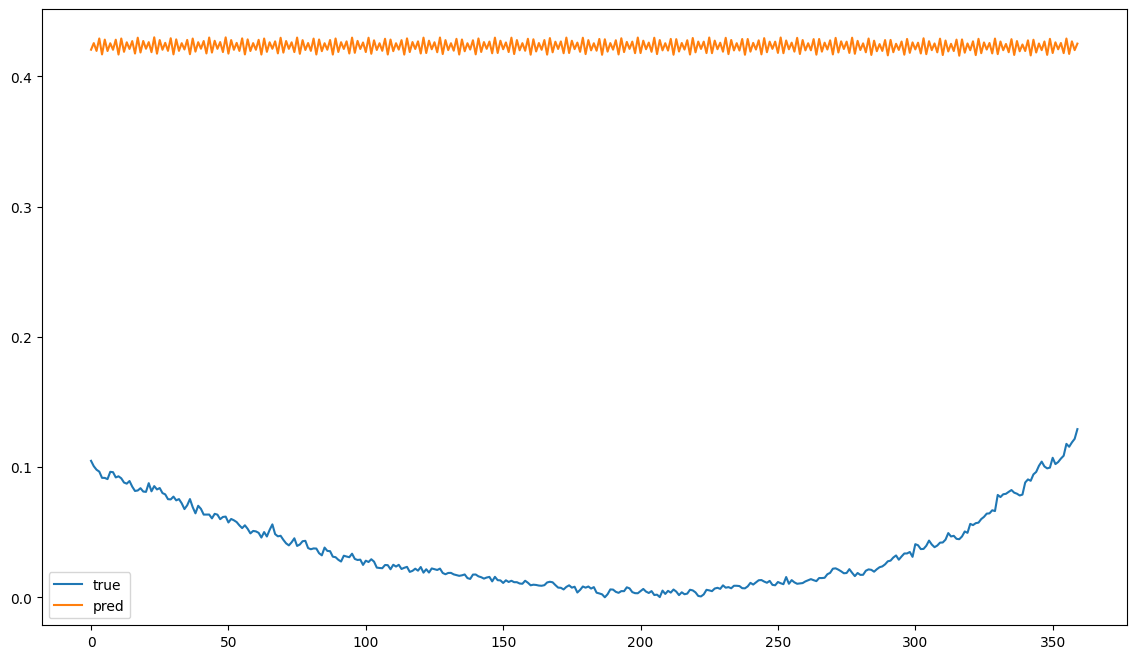

In [194]:
fig,axes = plt.subplots(1,1,figsize=(14,8))
axes.plot(np.arange(pred_len),data[['volumn']].values[-split+pred_len:-split+pred_len+pred_len],label='true')
axes.plot(np.arange(pred_len),predictions[0],label='pred')
plt.legend()